# Library Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')
%matplotlib inline
import lib.DB_lib as dl
import lib.Data_lib as dtl
import lib.VAE_lib as VAE
import lib.WGAN_lib as WGAN
from sklearn.decomposition import PCA
import torch
from joblib import dump, load
import Constants

# Constants

In [22]:
num_components = Constants.num_components
mills_for_1min = Constants.mills_for_1min
sample_rate_1h = Constants.sample_rate_1h
total_time_steps = Constants.test_total_time_steps
no_of_points = Constants.test_no_of_points
sliding_window_size = Constants.sliding_window_size
symbol = 'ethusdt'
interval = Constants.interval

vae_model_path = 'VAE_model/vae_model_ethusdt.pth'
min_max_scaler = 'scalar/min_max_scalar_ethusdt.pkl'
standard_scaler = 'scalar/standard_scalar_ethusdt.pkl'
wgan_x_scaler_path = 'trained_gan/wgan_x_scaler_ethusdt.pkl'
wgan_y_scaler_path = 'trained_gan/wgan_y_scaler_ethusdt.pkl'

In [23]:
def sliding_window(x, window):
    x_ = []
    for i in range(window, x.shape[0]):
        tmp_x = x[i - window: i, :]
        x_.append(tmp_x)
    x_ = torch.from_numpy(np.array(x_)).float()
    return x_

# Data Import

In [24]:
data_frame = dl.get_dataset_for_time_period(symbol, interval, total_time_steps)
data_frame['closet_time'] = pd.to_datetime(data_frame['closet_time'], unit='ms')
data_frame

,start_time,closet_time,open,close,high,low,volume,no_of_trades,quote_taker_ast_vol,buy_base_ast_vol,taker_buy_quote_ast_vol
0,1714788900000,2024-05-04 02:29:59.999,0.72620000,0.72810000,0.72980000,0.72600000,459065.30000000,620,334263.58599000,297371.40000000,216519.64546000
1,1714788000000,2024-05-04 02:14:59.999,0.72940000,0.72620000,0.72950000,0.72590000,673222.10000000,1190,489687.31299000,282117.60000000,205221.23923000
2,1714787100000,2024-05-04 01:59:59.999,0.73110000,0.72950000,0.73130000,0.72910000,192127.80000000,430,140281.42149000,80879.20000000,59062.91380000
3,1714786200000,2024-05-04 01:44:59.999,0.73440000,0.73130000,0.73440000,0.73080000,302716.70000000,504,221588.19687000,126075.70000000,92280.20110000
4,1714785300000,2024-05-04 01:29:59.999,0.73070000,0.73440000,0.73470000,0.73020000,413288.00000000,684,302473.81419000,224998.50000000,164697.86758000
...,...,...,...,...,...,...,...,...,...,...,...
6995,1708493400000,2024-02-21 05:44:59.999,1.00100000,0.99500000,1.00170000,0.99380000,1233751.10000000,3105,1230467.99322000,524160.90000000,522716.92027000
6996,1708492500000,2024-02-21 05:29:59.999,1.00420000,1.00090000,1.00460000,1.00000000,475056.60000000,1153,476084.02426000,208477.00000000,208903.86898000
6997,1708491600000,2024-02-21 05:14:59.999,1.00040000,1.00420000,1.00470000,0.99970000,528527.60000000,1589,529934.89750000,327165.30000000,328027.13623000
6998,1708490700000,2024-02-21 04:59:59.999,1.00540000,1.00030000,1.00590000,0.99600000,1648538.40000000,4688,1648988.45151000,844131.30000000,844381.73988000


## Create upper level DataFrame

In [25]:
df_list = []
for k in range(sample_rate_1h):
    df = pd.DataFrame()
    for i in range(no_of_points):
        ending_point = i*sample_rate_1h+k
        starting_point = (i+1)*sample_rate_1h-1+k
        closet_time = data_frame.loc[ending_point, 'closet_time']
        open_price = data_frame.loc[starting_point, 'open'] 
        close_price = data_frame.loc[ending_point, 'close'] 
        high_price = data_frame.loc[ending_point:starting_point, 'high'].max()
        low_price = data_frame.loc[ending_point:starting_point, 'low'].max()
        volume = data_frame.loc[ending_point:starting_point, 'volume'].sum()
        no_of_trades = data_frame.loc[ending_point:starting_point, 'no_of_trades'].sum()
        quote_taker_ast_vol = data_frame.loc[ending_point:starting_point, 'quote_taker_ast_vol'].sum()
        buy_base_ast_vol = data_frame.loc[ending_point:starting_point, 'buy_base_ast_vol'].sum()
        taker_buy_quote_ast_vol = data_frame.loc[ending_point:starting_point, 'taker_buy_quote_ast_vol'].sum()
        df = df._append({'closet_time': closet_time, 
                        'open': open_price, 
                        'close': close_price, 
                        'high': high_price, 
                        'low': low_price, 
                        'volume': volume, 
                        'no_of_trades': no_of_trades, 
                        'quote_taker_ast_vol': quote_taker_ast_vol, 
                        'buy_base_ast_vol': buy_base_ast_vol, 
                        'taker_buy_quote_ast_vol': taker_buy_quote_ast_vol}, ignore_index=True)
    df_list.append(df)   

for i in range(len(df_list)):
    print(df_list[i]['closet_time'])    

0     2024-05-04 02:29:59.999
1     2024-05-03 22:29:59.999
2     2024-05-03 18:29:59.999
3     2024-05-03 14:29:59.999
4     2024-05-03 10:29:59.999
                ...          
395   2024-02-28 06:29:59.999
396   2024-02-28 02:29:59.999
397   2024-02-27 22:29:59.999
398   2024-02-27 18:29:59.999
399   2024-02-27 14:29:59.999
Name: closet_time, Length: 400, dtype: datetime64[ns]
0     2024-05-04 02:14:59.999
1     2024-05-03 22:14:59.999
2     2024-05-03 18:14:59.999
3     2024-05-03 14:14:59.999
4     2024-05-03 10:14:59.999
                ...          
395   2024-02-28 06:14:59.999
396   2024-02-28 02:14:59.999
397   2024-02-27 22:14:59.999
398   2024-02-27 18:14:59.999
399   2024-02-27 14:14:59.999
Name: closet_time, Length: 400, dtype: datetime64[ns]
0     2024-05-04 01:59:59.999
1     2024-05-03 21:59:59.999
2     2024-05-03 17:59:59.999
3     2024-05-03 13:59:59.999
4     2024-05-03 09:59:59.999
                ...          
395   2024-02-28 05:59:59.999
396   2024-02-28 01:59

# Data Visualization & Preprocess

In [26]:
use_cuda = 0
device = "cpu"
output = []
for i in range(len(df_list)):
    dataset_ex_df = df_list[i]
    dataset_ex_df = dataset_ex_df.iloc[::-1]
    dataset_ex_df.reset_index(drop=True, inplace=True)
    #--------------------------------------------------------------------------------------------------------
    dataset_ex_df['pct_change'] = (dataset_ex_df['close'] - dataset_ex_df['close'].shift(1))/ dataset_ex_df['close'].shift(1)
    dataset_ex_df['log_change'] = np.log((dataset_ex_df['close']/ dataset_ex_df['close'].shift(1)).astype(float))
    dataset_ex_df['prev_close'] = dataset_ex_df['close'].shift(2)
    dataset_ex_df = dataset_ex_df.dropna()
    #-------------------------------------------------------------------------------------------------------
    dataset_Idc = dtl.CreateInc(dataset_ex_df,"close","high","low","volume")
    #--------------------------------------------------------------------------------------------------------
    close_fft = np.fft.fft(np.asarray(dataset_Idc['close'].tolist()))
    fft_df = pd.DataFrame({'fft':close_fft})
    fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
    fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
    output_df_fft = fft_df.copy()
    
    fft_list = np.asarray(fft_df['fft'].tolist())
    for num_ in [3, 6, 9, 27, 81, 100]:
        fft_list_m10= np.copy(fft_list) 
        fft_list_m10[num_:-num_]=0
        output_df_fft[f'FT_{num_}components'] = np.fft.ifft(fft_list_m10).astype('float')
        
    df_idc_fft = pd.concat([dataset_Idc,output_df_fft[["FT_3components","FT_6components","FT_9components","FT_27components","FT_81components","FT_100components"]]], axis=1)
    
    #--------------------------------------------------------------------------------------------------
    # data = df_idc_fft.iloc[:,1:]
    # data.drop('close', axis=1, inplace=True)
    # features = data.shape[1]
    # x = data.values
    # x_scaler = load(min_max_scaler)
    # train_x = x_scaler.fit_transform(x)
    # model = VAE.VAE([features, 400, 400, 400, 10], 10)
    # model.load_state_dict(torch.load(vae_model_path))
    # model.eval()
    # _, VAE_train_x, train_x_mu, train_x_var = model(torch.from_numpy(train_x).float().to(device))
    # df_tr = pd.DataFrame(VAE_train_x.cpu().detach().numpy(), columns=['enc1', 'enc2', 'enc3', 'enc4', 'enc5', 'enc6', 'enc7', 'enc8', 'enc9', 'enc10'])
    # df_idc_fft_vae = pd.concat([df_idc_fft, df_tr], axis=1)
    # df_idc_fft = df_idc_fft_vae
    #-------------------------------------------------------------------------------------------------------------------
    
    
    df_pca=df_idc_fft.drop(['closet_time'], axis=1)
    X = df_pca.values # matrix of dataframe 
    sc = load(standard_scaler)
    X_std = sc.fit_transform(X) # standardizing the data
    pca = PCA(num_components)  
    X_pca = pca.fit_transform(X_std)
    df_PCA=X_pca.copy()
    df_PCA = pd.DataFrame(df_PCA,columns=["pca1","pca2","pca3","pca4","pca5","pca6","pca7","pca8","pca9","pca10","pca11","pca12","pca13","pca14","pca15","pca16","pca17"])
    
    #-----------------------------------------------------------------------------------------------------------------------

    output.append(df_PCA)

C:\Users\KAVISHKA\AppData\Local\Temp\ipykernel_24556\1734348001.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_ex_df['pct_change'] = (dataset_ex_df['close'] - dataset_ex_df['close'].shift(1))/ dataset_ex_df['close'].shift(1)
C:\Users\KAVISHKA\AppData\Local\Temp\ipykernel_24556\1734348001.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_ex_df['log_change'] = np.log((dataset_ex_df['close']/ dataset_ex_df['close'].shift(1)).astype(float))
C:\Users\KAVISHKA\AppData\Local\Temp\ipykernel_

#### Initial Shape of the BTC Dataset

In [27]:
output[0].tail(11)

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14,pca15,pca16,pca17
100,1.180268,-4.596417,1.174471,-0.755099,-0.657500,2.134307,-0.224966,-0.689835,-0.974474,0.448212,0.243972,-0.045066,0.140452,0.010306,0.056650,-0.023872,-0.147823
101,0.541927,-2.872353,1.886495,2.303138,-0.039801,2.216950,0.139858,-0.968400,-0.489341,0.212960,0.341287,0.068955,-0.218029,-0.074978,0.085397,0.107212,0.121727
102,-1.062400,-3.571319,1.813643,0.166460,0.155044,2.155988,0.232612,-0.731829,-0.289843,0.298341,0.363914,0.039731,-0.119572,-0.216188,-0.076610,-0.070618,-0.016159
103,-2.320303,-3.546587,2.093196,-0.163379,-0.071766,2.204366,0.273531,-0.644866,0.089901,0.336691,0.426643,-0.078294,-0.168756,-0.320604,-0.077049,0.040372,-0.096145
104,-3.023571,-3.076956,2.069260,0.130341,0.475358,2.374736,0.428439,-0.528846,0.291296,0.460022,0.458555,-0.015164,0.196570,-0.311910,-0.107971,0.004167,-0.316345
105,-3.044525,-3.130863,0.978786,-1.114883,1.300013,2.188116,0.141484,-0.467983,0.433175,0.492289,0.370649,0.104524,-0.070941,-0.319022,-0.036418,-0.054003,-0.096067
106,-3.341923,-3.168924,0.926816,-1.000134,0.201669,1.896771,-0.118461,-0.619944,0.586824,0.464288,-0.077921,0.333720,-0.263343,-0.250315,0.009148,0.018730,-0.025431
107,-3.349930,-1.648323,1.499807,2.270637,-0.095087,1.973362,0.116525,-0.990851,0.774219,0.054719,-0.276256,0.623202,-0.018430,-0.093153,-0.033313,-0.081462,0.039242
108,-4.473209,-2.320353,1.045261,-0.111721,0.282159,2.094363,0.241342,-0.768915,0.666248,-0.150884,-0.454298,0.418453,0.425738,-0.168896,0.075514,-0.215110,0.077301
109,-5.014449,-2.033821,1.018427,-0.041871,0.018979,2.009131,0.243683,-0.799010,0.863547,-0.424238,-0.825928,0.280117,0.273566,-0.203989,0.121604,-0.019585,-0.095984


In [28]:
wgan_x_scaler = load(wgan_x_scaler_path)
wgan_y_scaler = load(wgan_y_scaler_path)
modelG2 = WGAN.Generator(output[0].shape[1])
modelG2.load_state_dict(torch.load("trained_gan/modelG1.pth",map_location=torch.device('cpu')))
# modelG2.eval()

final = []
for i in range(len(output)):
    test_x = output[i].tail(11)
    test_x = wgan_x_scaler.transform(test_x)
    test_x_slide = sliding_window(test_x, sliding_window_size)
    pred_y_train, gru_output = modelG2(test_x_slide)
    y_test_pred  = wgan_y_scaler.inverse_transform(pred_y_train.detach().numpy())
    final.append(y_test_pred[0][0])

In [29]:
final

[0.7185311,
 0.7098002,
 0.6881038,
 0.692621,
 0.71451396,
 0.70124674,
 0.7126918,
 0.6902469,
 0.71475625,
 0.7032199,
 0.7014714,
 0.71313065,
 0.6988215,
 0.71950847,
 0.7283853,
 0.73321587]

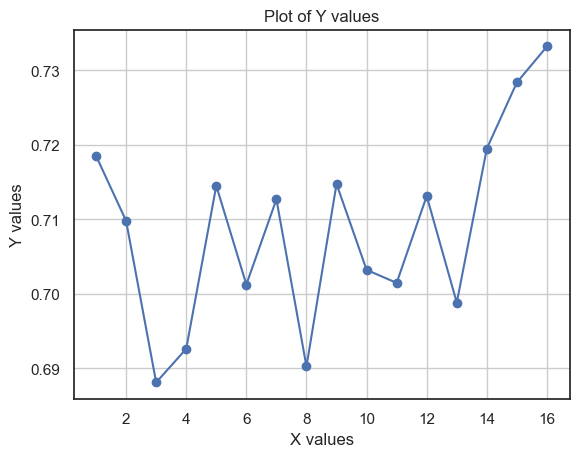

In [30]:
import matplotlib.pyplot as plt

# Generate x values starting from 1
x_values = range(1, len(final) + 1)

# Plot
plt.plot(x_values, final, marker='o')
plt.xlabel('X values')
plt.ylabel('Y values')
plt.title('Plot of Y values')
plt.grid(True)
plt.show()

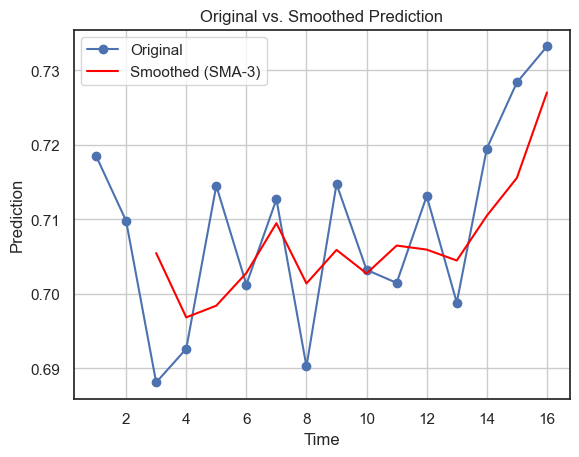

In [31]:
# Apply simple moving average (SMA) with window size 3
window_size = 3
smoothed_values = np.convolve(final, np.ones(window_size)/window_size, mode='valid')

# Plot original and smoothed prediction values
plt.plot(range(1, len(final) + 1), final, label='Original', marker='o')
plt.plot(range(window_size, len(final) + 1), smoothed_values, label=f'Smoothed (SMA-{window_size})', color='red')
plt.xlabel('Time')
plt.ylabel('Prediction')
plt.title('Original vs. Smoothed Prediction')
plt.legend()
plt.grid(True)
plt.show()